In [4662]:
import pandas as pd
from tdmsdata import TdmsData
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit   
import os
import importlib
import doppler_shift_2024


In [4663]:
folder_path = '/Users/xnimir/Desktop/Sn exp/online analysis 2024/set4/'
# files = ('20241022_1929_Sn_res_1536.45_1536.55.tdms','20241022_1929_Sn_res_1536.45_1536.55_halfpower.tdms')
# path = '/Users/xnimir/Desktop/Sn exp/online analysis 2024'
# subfolder = 'set3'

# folder_path = os.path.join(path, subfolder)

In [4664]:
def read_tdms(file, channel):
    TDMS = TdmsData(''.join([folder_path, file]))
    raw_data = TDMS.get_raw_data(''.join(['Channel ', str(channel)]))  # 2D np array
    return raw_data

In [4665]:
def create_df(raw_data):
    return pd.DataFrame({'Cycle No.': raw_data[:, 0], 'Time (sec)': raw_data[:, 1], 
                         'Laser Frequency (THz)': raw_data[:, 2]})

In [4666]:
def doppler_shift_calc(dataset, isotope):
    importlib.reload(doppler_shift_2024)
    doppler_df = dataset.copy()
    freq = doppler_df['Laser Frequency (THz)']
    shifted_freq = doppler_shift_2024.getshift(freq, isotope)
    doppler_df['Laser Frequency (THz)'] = shifted_freq

    return doppler_df

In [4667]:
def process_tdms(raw_df, bins, isotope, file):
    # print(raw_df)
    wavelengths_raw = raw_df['Laser Frequency (THz)']
    wavelengths_raw = pd.to_numeric(wavelengths_raw, errors='coerce')
    wavelengths_raw = wavelengths_raw.dropna()
    counts_df = pd.DataFrame({'Freq': wavelengths_raw})
    counts_df = wavelengths_raw.value_counts().reset_index()
    counts_df.columns = ['Freq', 'Count']

    if isotope == 122 or isotope == 116:
        counts_df = counts_df.iloc[2:].reset_index(drop=True)

    if 'ref2' in file: 
        counts_df = counts_df.iloc[1:].reset_index(drop=True)
    # min_freq = 
    # max_freq = 
    # counts_df = counts_df[(counts_df['Freq'] < min_freq) | (counts_df['Freq'] > max_freq)].reset_index(drop=True)

        
    counts_df = counts_df.sort_values(by='Freq', ascending=True).reset_index()

    raw_df['Time bin'] = pd.cut(raw_df['Time (sec)'], bins)
    binned_df = raw_df.groupby('Time bin', observed=True).size().reset_index(name='Count')
    binned_df['Bin center'] = binned_df['Time bin'].apply(lambda x: x.mid)
    binned_df.columns = ['Time bin', 'Count', 'Bin center']

    # avg_count_5_sec = binned_df[binned_df['Bin center'] <= 5]['Count'].mean() # average bkg 
    # binned_df.loc[binned_df['Bin center'] < 15, 'Count'] = avg_count_5_sec
    
    return counts_df, binned_df

In [4668]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

In [4669]:
def lorentzian(x, A, x0, gamma):
    return (A / np.pi) * (gamma / ((x - x0) ** 2 + gamma ** 2))

In [4670]:
def get_scatter_plot(counts_df, binned_df, file, isotope):
    # freqs = counts_df['Bin center'].cat.categories.astype(float)
    freqs = counts_df['Freq']
    counts = counts_df['Count']

    time = binned_df['Bin center'].cat.categories.astype(float)
    counts_time = binned_df['Count']


    # plt binned counts 
    plt.scatter(freqs, counts)
    plt.xlabel('Freq THz')
    plt.ylabel('Count')
    plt.title(f'{file}')
    # plt.ylim(0,3000)
    # freq_range = (195.092, 195.098)
    # freq_range = (None)
    # plt.xlim(freq_range[0], freq_range[1])

 
    # if '25' in file:
    #     plt.ylim(-100,1500)
    # # if '11' in file:
    # #     plt.ylim(0,1000)
    # # plt.show()

    
    # range_mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
    # freqs_in_range = freqs[range_mask]
    # counts_in_range = counts[range_mask]

    # print(range_mask)
    # print(freqs_in_range)
    # print(counts_in_range)

    # initial_guess = [max(countse), freqs_in_range[np.argmax(counts_in_range)], 0.001]
    initial_guess = [max(counts), freqs[np.argmax(counts)], 0.001]
    print(initial_guess) 

    # x_fit = np.linspace(freq_range[0], freq_range[1], 100)
    x_fit = np.linspace(min(freqs), max(freqs), 100)


    # popt, pcov = curve_fit(gaussian, freqs, counts, p0=initial_guess)
    # A, mu, sigma = popt 
    # y_fit = gaussian(x_fit, A, mu, sigma)
    # fwhm = (2 * np.sqrt(2 * np.log(2)) * popt[2]) * 1E6

    popt, pcov = curve_fit(lorentzian, freqs, counts, p0=initial_guess)
    A, mu, gamma = popt 
    y_fit = lorentzian(x_fit, A, mu, gamma)
    fwhm = (gamma * 2) * 1E6 
    
    plt.plot(x_fit, y_fit, color='red', label = f'max={popt[1]:.6f} THz, fwhm={fwhm:.2f} MHz')
    plt.legend(loc='center right', fontsize=8)
    plt.show()

    plt.scatter(time, counts_time)
    plt.xlabel('Time s')
    plt.ylabel('binned time counts')
    plt.title(f'{file}')
    # plt.ylim(0,1000)
    plt.show()

    return popt[1], fwhm

[7885, 194.95389162051234, 0.001]


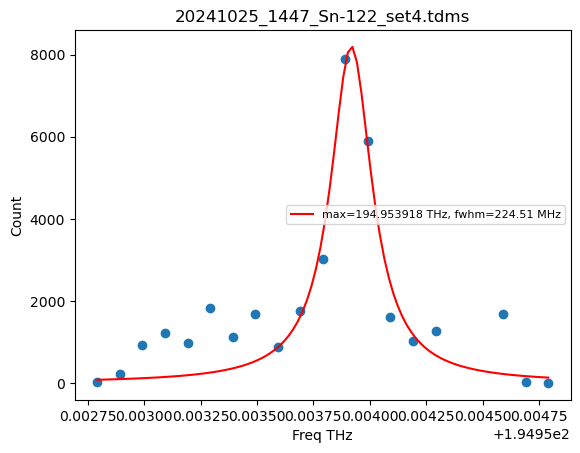

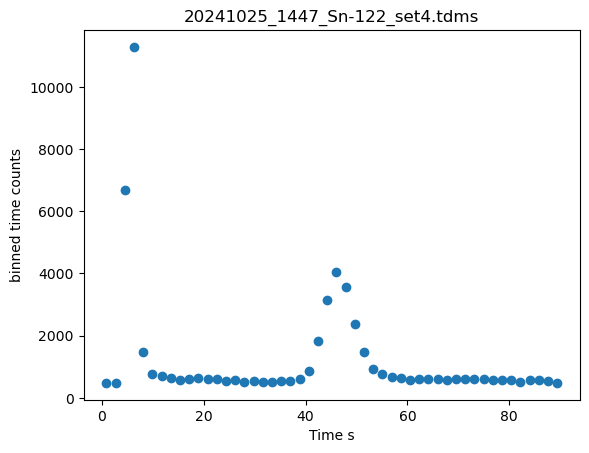

[13033, 194.95151690638687, 0.001]


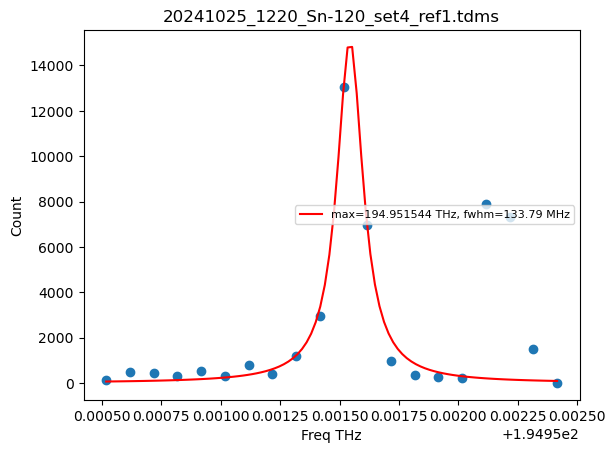

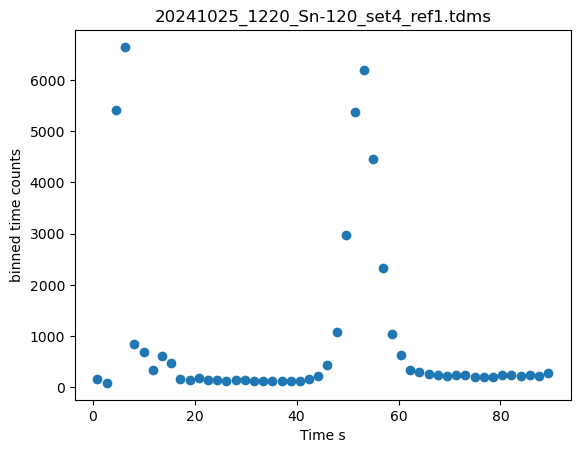

[8299, 194.95161683314896, 0.001]


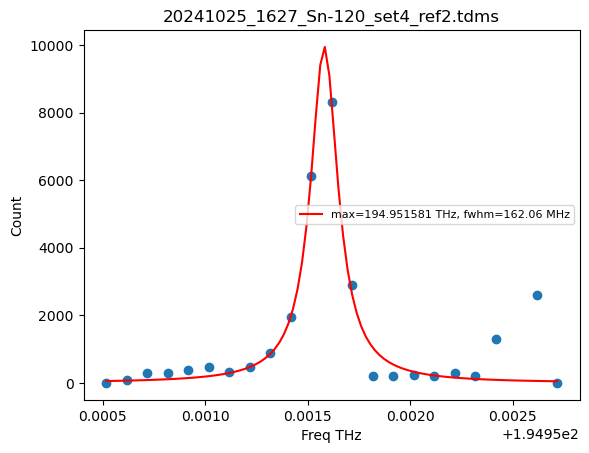

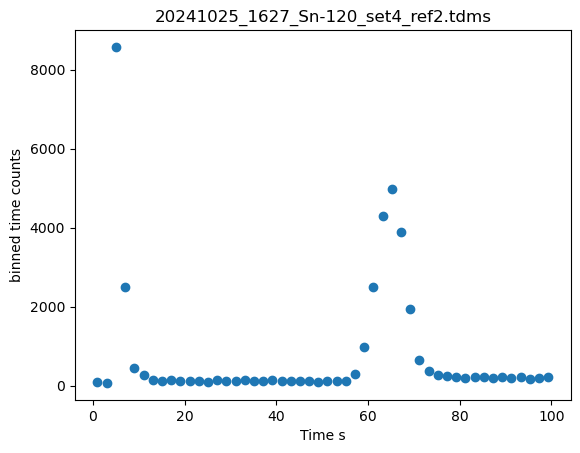

[9865, 194.94921237786326, 0.001]


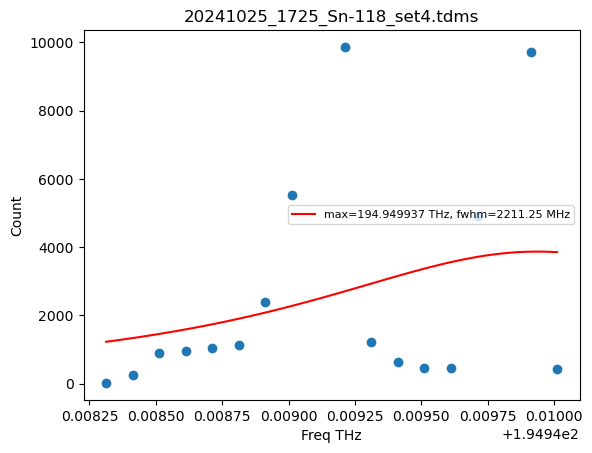

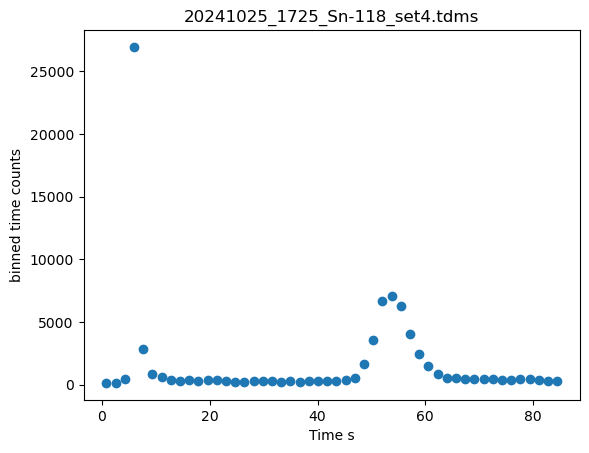

[8419, 194.94667698022872, 0.001]


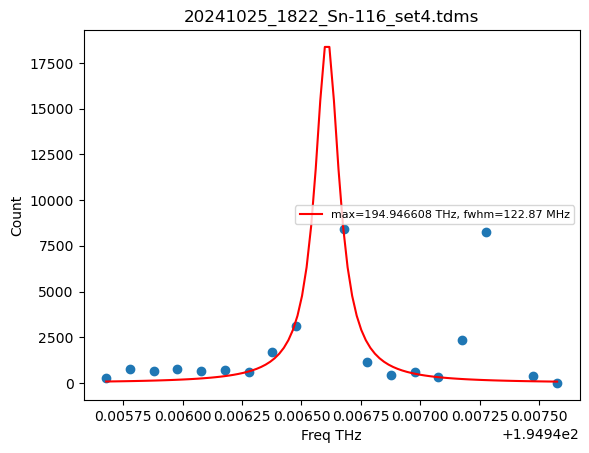

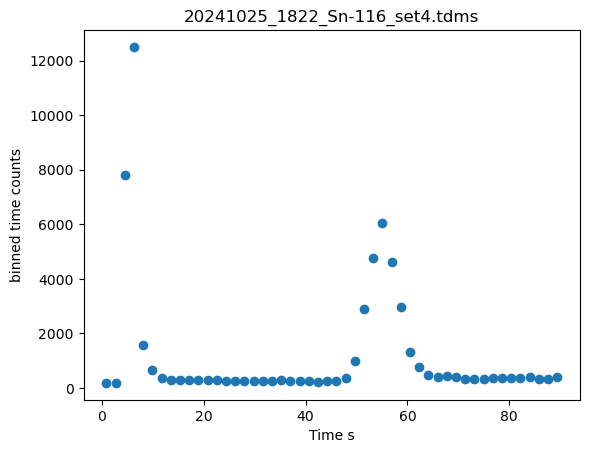

[6094, 194.95633772599507, 0.001]


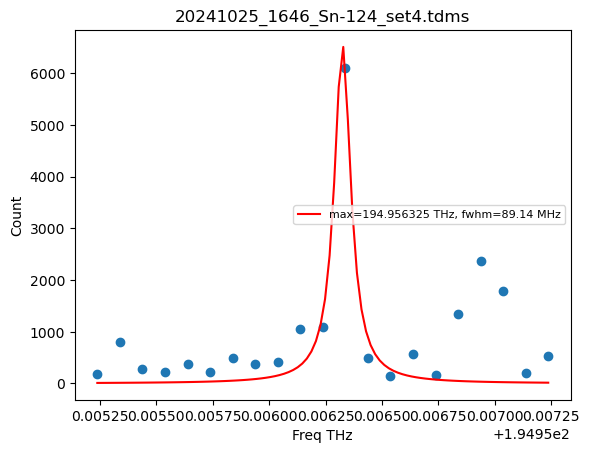

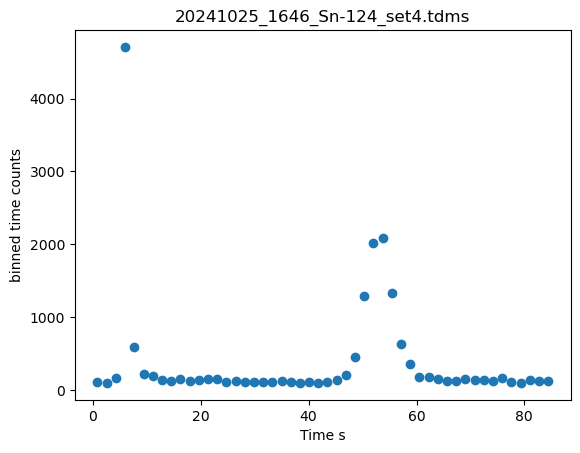

[9364, 194.95161683314896, 0.001]


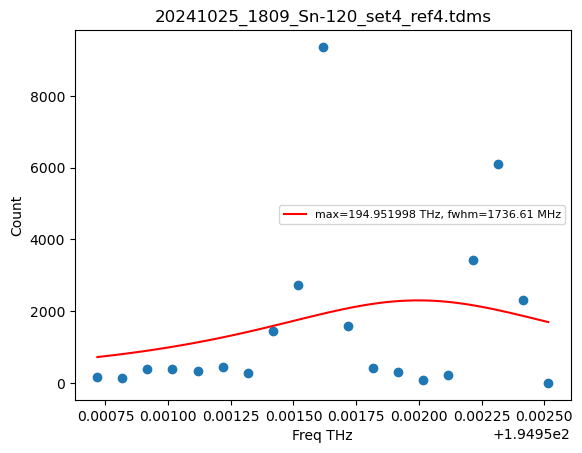

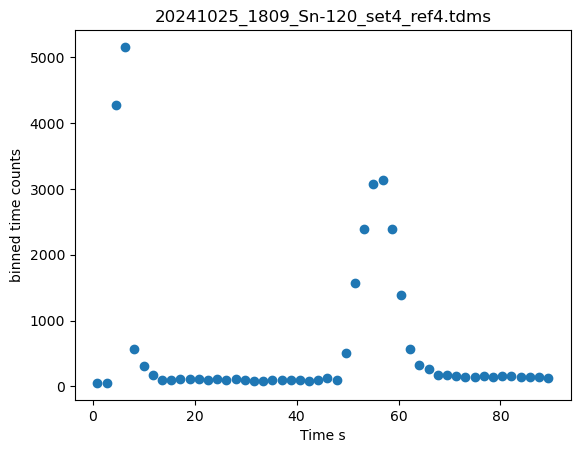

[10915, 194.95633772599507, 0.001]


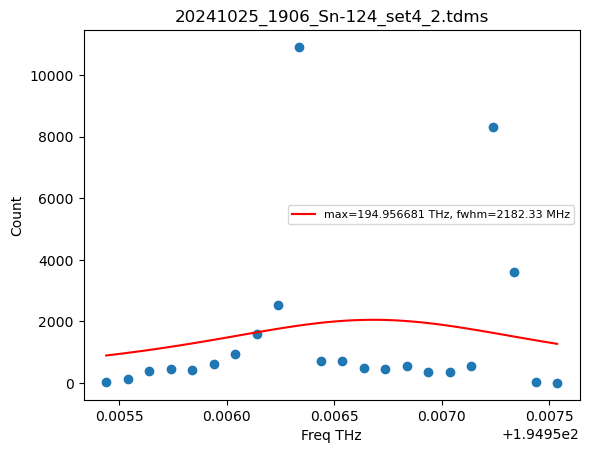

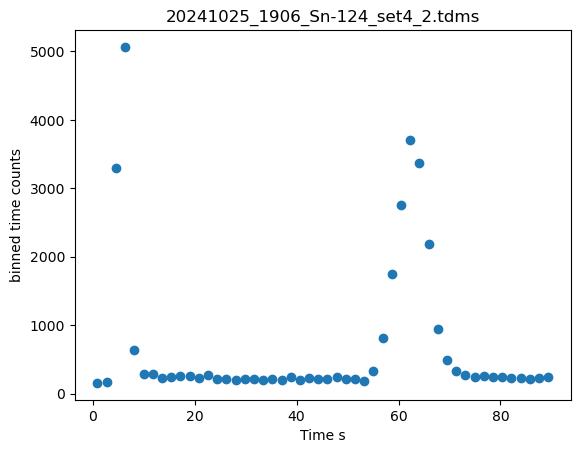

[2073, 194.95161683314896, 0.001]


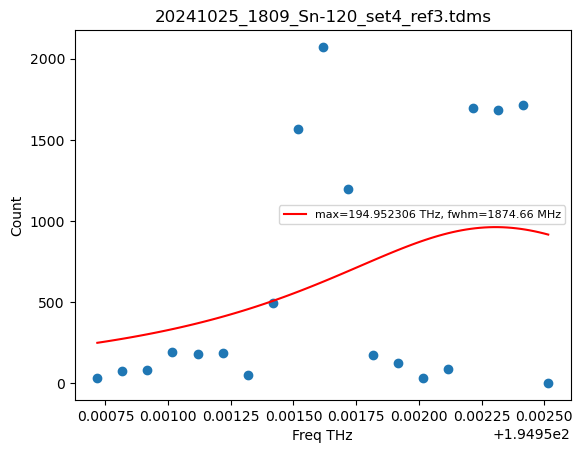

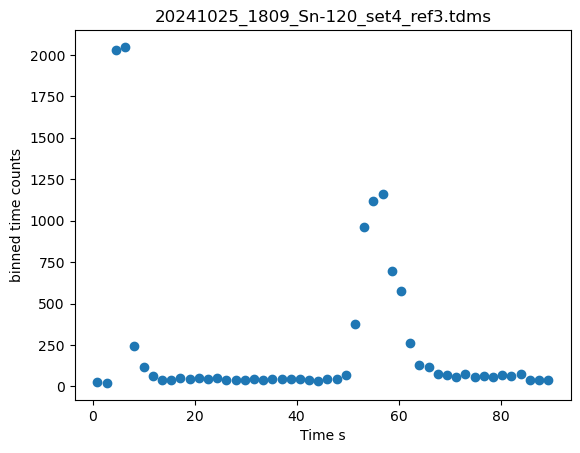

In [4671]:
bins=50
peaks_120 = []
fwhms_120 = []

for filename in os.listdir(folder_path):
    # if 'sn-120' in filename.lower() and filename.endswith('.tdms'):
    if filename.endswith('.tdms'):
        if '120' in filename:
            isotope = 120
            # freq_range = (195.0938, 195.0955)
            freq_range = None
        elif '122' in filename:
            isotope = 122
        elif '124' in filename:
            isotope = 124
            # freq_range = (195.096, 195.098)
        elif '116' in filename:
            isotope = 116
        #     freq_range = (195.091, 195.0925)
        elif '118' in filename:
            isotope = 118
        #     freq_range= (195.0925, 195.094)
        elif '112' in filename: 
            isotope = 112

        raw_data = read_tdms(filename, channel=1)
        raw_df = create_df(raw_data)
        doppler_df = doppler_shift_calc(raw_df, isotope)
        counts_df, binned_df = process_tdms(doppler_df, bins, isotope, filename)

        # binned_counts_df = binned_counts_df1.copy()
        # binned_counts_df['Count'] = binned_counts_df1['Count'] - binned_counts_df5['Count']
        # print(binned_counts_df1)
        peak, fwhm = get_scatter_plot(counts_df, binned_df, filename, isotope)
        peaks_120.append(peak)
        fwhms_120.append(fwhm)

# xlin = np.linspace(0, 5, 5)
# yerr = np.std(peaks_120)/np.sqrt(5)

# plt.errorbar(xlin, peaks_120, yerr = yerr, fmt='o')
# plt.show()


# time = raw_df['Time (sec)']
# freq_raw = raw_df['Laser Frequency (THz)']


# plt.scatter(time,freq_raw)


In [4672]:
def plot_all(): 
    all_freqs = []
    all_counts = []
    x_fits = []
    y_fits = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.tdms'):
            if '120' in filename:
                isotope = 120
            elif '122' in filename:
                isotope = 122
            elif '124' in filename:
                isotope = 124
            elif '116' in filename:
                isotope = 116
            elif '118' in filename:
                isotope = 118
            elif '112' in filename: 
                isotope = 112

            raw_data = read_tdms(filename, channel=1)
            raw_df = create_df(raw_data)
            doppler_df = doppler_shift_calc(raw_df, isotope)
            counts_df, binned_df = process_tdms(doppler_df, bins, isotope, filename)

            freqs = counts_df['Freq']  
            counts = counts_df['Count']  

            x_fit = np.linspace(min(freqs), max(freqs), 100)
            initial_guess = [max(counts), freqs[np.argmax(counts)], 0.001]

            popt, pcov = curve_fit(lorentzian, freqs, counts, p0=initial_guess)
            A, mu, gamma = popt 
            y_fit = lorentzian(x_fit, A, mu, gamma)
            fwhm = (gamma * 2) * 1E6 
    
            all_freqs.append(freqs)
            all_counts.append(counts)
            x_fits.append(x_fit)
            y_fits.append(y_fit)
            labels.append(f"Isotope {isotope}")

    for x_fit, y_fit, label in zip(x_fits, y_fits, labels):
        plt.plot(x_fit, y_fit, label=label) 

    plt.xlabel('Frequency (THz)')  
    plt.ylabel('Count') 
    plt.legend()  
    plt.show()


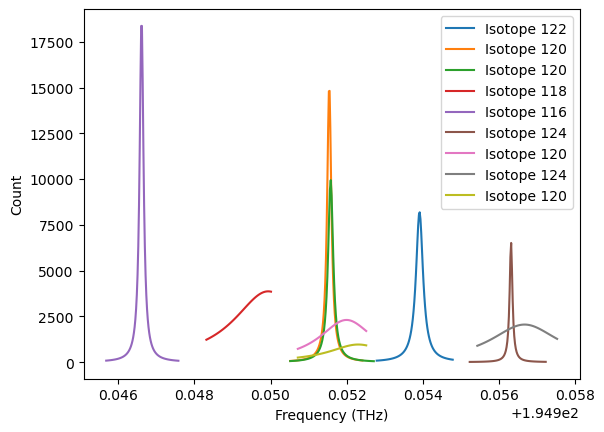

In [4673]:
plot_all()